In [1]:
%matplotlib inline

from matplotlib import rc
from fourierPSF.fourierModel import *
from fourierPSF.FourierUtils import *
from configparser import ConfigParser

from mavis import *

rc("text", usetex=False)

In [2]:
def overallSimulation(path, parametersFile, windPsdFile, outputDir, outputFile, path_pupil='', pitchScaling=1,doConvolve=False):
    
    # initiate the parser
    fullPathFilename = path + parametersFile + '.ini'    
    parser           = ConfigParser()
    parser.read(fullPathFilename);
    
    # read main parameters
    wvl        = eval(parser.get('PSF_DIRECTIONS', 'ScienceWavelength'))[0]  # lambda
    wvl_LO     = eval(parser.get('SENSOR_LO', 'SensingWavelength_LO'))  # lambda
    pixel_psf  = eval(parser.get('PSF_DIRECTIONS', 'psInMas'))
    tel_radius = eval(parser.get('telescope', 'TelescopeDiameter'))/2      # mas
    LO_zen     = eval(parser.get('SENSOR_LO', 'GuideStarZenith_LO')) 
    LO_az      = eval(parser.get('SENSOR_LO', 'GuideStarAzimuth_LO'))
    fluxes     = eval(parser.get('SENSOR_LO', 'nph_LO'))
    fr         = eval(parser.get('SENSOR_LO', 'SensorFrameRate_LO'))
    zenithSrc  = np.array(eval(parser.get('PSF_DIRECTIONS', 'ScienceZenith')))
    azimuthSrc = np.array(eval(parser.get('PSF_DIRECTIONS', 'ScienceAzimuth')))
    
    # NGSs positions
    polarNGSCoordsList = [[LO_zen[0],LO_az[0]], [LO_zen[1],LO_az[1]],[LO_zen[2],LO_az[2]]]
    NGS_flux           = [fluxes[0]*fr, fluxes[1]*fr, fluxes[2]*fr]
    polarNGSCoords     = np.asarray(polarNGSCoordsList)
    pp                 = polarToCartesian(np.array( [zenithSrc, azimuthSrc]))
    xxPointigs         = pp[0,:]
    yyPointigs         = pp[1,:]

    # bypass the dm cut off frequency definition
    if pitchScaling != 1:
        pitchs_dm    = np.array(eval(parser.get('DM', 'DmPitchs')))
        kcExt        = 1/(2*pitchs_dm.min()*pitchScaling)
    else:
        kcExt = None
        
    
    # High-order PSD caculations at the science directions and NGSs directions
    fao = fourierModel(fullPathFilename, calcPSF=False, verbose=False, display=False, \
                   cartPointingCoords=np.array([xxPointigs, yyPointigs]).transpose() , extraPSFsDirections=polarNGSCoordsList, \
                      kcExt=kcExt,pitchScaling=pitchScaling,path_pupil=path_pupil)
    PSD           = fao.powerSpectrumDensity() # in nm^2
    PSD           = PSD.transpose()
    N             = PSD[0].shape[0]    
    freq_range    = fao.fovInPixel*fao.PSDstep # fao.psf_FoV/fao.wvlRef/206264.8
    pitch         = 1/freq_range
    grid_diameter = pitch*N
    sx            = int(2*np.round(tel_radius/pitch))
    dk            = 1e9*fao.kc/fao.resAO
    
    # Define the pupil shape
    mask = Field(wvl, N, grid_diameter)
    mask.sampling = cp.asarray(congrid(fao.tel.pupil, [sx, sx]))
    mask.sampling = zeroPad(mask.sampling, (N-sx)//2)
    #mask.standardPlot(False)
    print('fao.samp:', fao.samp)
    
    def psdSetToPsfSet(inputPSDs,wavelength,pixelscale,scaleFactor=1,verbose=False):
        NGS_SR = []
        psdArray = []
        psfLongExpArr = []
        NGS_FWHM_mas = []
        for computedPSD in inputPSDs:    
            # Get the PSD at the NGSs positions at the sensing wavelength
            psd            = Field(wavelength, N, freq_range, 'rad')
            psd.sampling   = cp.asarray( computedPSD / dk**2) # the PSD must be provided in m^2.m^2
            psdArray.append(psd)
            # Get the PSF
            psfLE          = longExposurePsf(mask, psd )     
            psfLongExpArr.append(psfLE)
            # Get SR and FWHM in mas at the NGSs positions at the sensing wavelength
            SR             = np.exp(-computedPSD.sum()* scaleFactor) # Strehl-ratio at the sensing wavelength
            #SR              = getStrehl(cp.asnumpy(psfLE.sampling), fao.tel.pupil, fao.samp)
            NGS_SR.append(SR)
            FWHMx,FWHMy    = getFWHM( cp.asnumpy(psfLE.sampling),pixelscale, method='contour', nargout=2)
            FWHM           = 0.5*(FWHMx+FWHMy) #average over major and minor axes
            NGS_FWHM_mas.append(FWHM)
            if verbose == True:
                print('SR at the sensing wavelength:', SR)            
                print('FWHM at the sensing wavelength:', FWHM)            
            
        return NGS_SR, psdArray, psfLongExpArr, NGS_FWHM_mas

    # HO PSF
    pointings_SR, psdPointingsArray, psfLongExpPointingsArr, pointings_FWHM_mas = psdSetToPsfSet(PSD[:-3],wvl,fao.psInMas,scaleFactor=(2*np.pi*1e-9/wvl)**2)
     
        
    if doConvolve == False:
        results = psfLongExpPointingsArr
    else:
        # LOW ORDER PART
        psInMas_NGS        = fao.psInMas * (wvl_LO/wvl) #airy pattern PSF FWHM
        NGS_SR, psdArray, psfLE_NGS, NGS_FWHM_mas = psdSetToPsfSet(PSD[-3:],wvl_LO,psInMas_NGS,scaleFactor=(2*np.pi*1e-9/wvl_LO)**2,verbose=True)
        cartPointingCoords = np.dstack( (xxPointigs, yyPointigs) ).reshape(-1, 2)
        cartNGSCoords      = np.asarray([polarToCartesian(polarNGSCoords[0,:]), polarToCartesian(polarNGSCoords[1,:]), polarToCartesian(polarNGSCoords[2,:])])
        mLO                = MavisLO(path, parametersFile, windPsdFile)
        Ctot               = mLO.computeTotalResidualMatrix(np.array(cartPointingCoords), cartNGSCoords, NGS_flux, NGS_SR, NGS_FWHM_mas)
        cov_ellipses       = mLO.ellipsesFromCovMats(Ctot)
        #print(cov_ellipses)
    
        # FINAl CONVOLUTION
        results = []
        for ellp, psfLongExp in zip(cov_ellipses, psfLongExpPointingsArr):
            results.append(convolve(psfLongExp, residualToSpectrum(ellp, wvl, N, 1/(fao.fovInPixel * fao.psInMas))))
        
    results[0].standardPlot(True)
    
    # save PSF cube in fits    
    hdul1 = fits.HDUList()
    cube =[]
    hdul1.append(fits.PrimaryHDU())
    for img in results:
        cube.append(cp.asnumpy(img.sampling))
    
    cube = np.array(cube)
    hdul1.append(fits.ImageHDU(data=cube))
    hdul1.writeto( outputDir + outputFile + '.fits',overwrite=True)
    print(cube.shape)

fao.samp: 1.0
SR at the sensing wavelength: 0.7804932553586611
FWHM at the sensing wavelength: 42.618575446934216
SR at the sensing wavelength: 0.7389666606547277
FWHM at the sensing wavelength: 42.62451504367685
SR at the sensing wavelength: 0.7300195376148843
FWHM at the sensing wavelength: 42.62499701578243


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


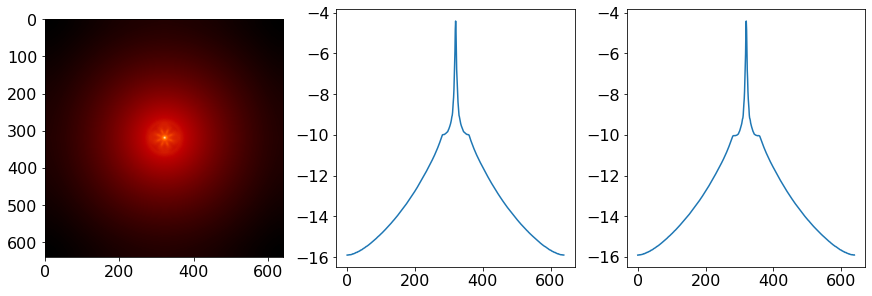

(16, 640, 640)
fao.samp: 1.0
SR at the sensing wavelength: 0.7804314338933349
FWHM at the sensing wavelength: 42.6117634625502
SR at the sensing wavelength: 0.7388978288544076
FWHM at the sensing wavelength: 42.61770038544459
SR at the sensing wavelength: 0.7299492984059666
FWHM at the sensing wavelength: 42.618182518504945


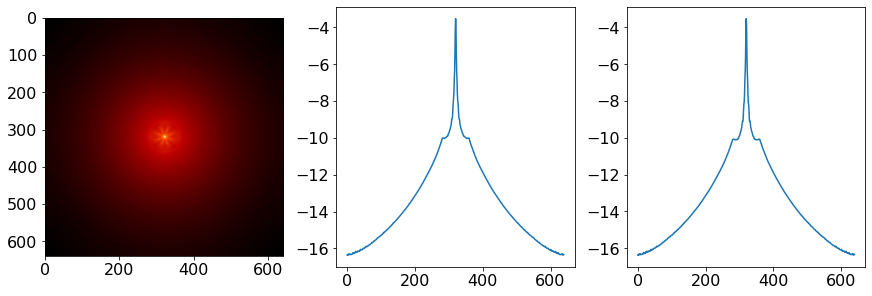

(16, 640, 640)
fao.samp: 1.0
SR at the sensing wavelength: 0.7849859244477108
FWHM at the sensing wavelength: 42.59164685996867
SR at the sensing wavelength: 0.7441332709311411
FWHM at the sensing wavelength: 42.59757597660084
SR at the sensing wavelength: 0.7353226248652385
FWHM at the sensing wavelength: 42.59805860921715


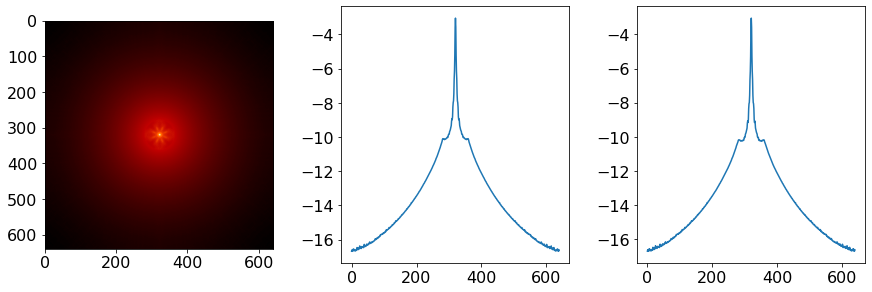

(16, 640, 640)
fao.samp: 1.0
SR at the sensing wavelength: 0.7804211678613368
FWHM at the sensing wavelength: 42.607630297332136
SR at the sensing wavelength: 0.738849383896351
FWHM at the sensing wavelength: 42.613565685247124
SR at the sensing wavelength: 0.7298895685152316
FWHM at the sensing wavelength: 42.61404794462824


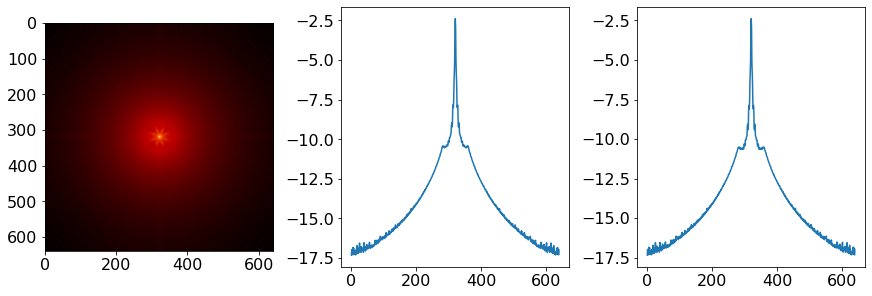

(16, 640, 640)
Done


In [3]:
# MAVIS SIMULATIONS
#baseInputPath = '/data7/guido/results/MAVIS/res4psf/20201116_111006.0_oaPSFs_w'
#baseOutpuPath = '/data4/olivierbm/phaseB/fourierVe2e/MAVIS/fourierHO_LO/'
#windPsdFile = 'data/windpsd_mavis.fits'
baseInputPath = '/data7/guido/results/MAVIS/res4psf/20201116_111006.0_oaPSFs_w'
baseOutpuPath = '/data4/frossi/'
windPsdFile = 'data/windpsd_mavis.fits'

wvlPaths = ['450','550','640','890']
k=-1
for wvlPath in wvlPaths:
    k+=1
    fullInputPath = baseInputPath + wvlPath + 'nm/'
    parametersFile = 'params'
    outputFile = 'simulation' + wvlPath + 'nm'
    overallSimulation(fullInputPath, parametersFile, windPsdFile, baseOutpuPath, outputFile,doConvolve=True,pitchScaling = 0.9)
print('Done')

In [4]:
path = "/home/frossi/dev/MASTSEL/"
parametersFile = 'mavisParams'
windPsdFile = 'data/windpsd_mavis.fits'
baseOutpuPath = '/data4/frossi/'

# overallSimulation(path, parametersFile, windPsdFile, baseOutpuPath, "test", hh=0)

In [5]:
# NGS_flux = [10000, 30000, 5000]
# old values: NGS_SR_1650 = [0.4, 0.2, 0.6]
# old values: NGS_FWHM_mas = [90, 110, 85]